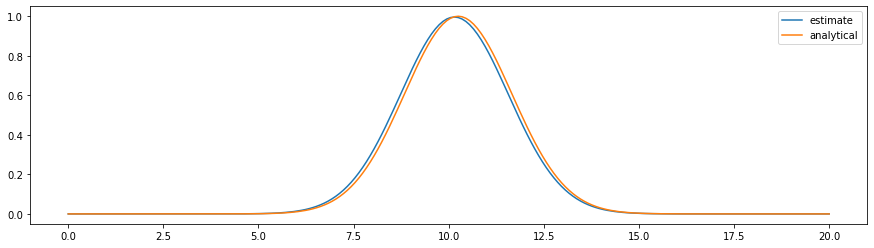

In [1]:
from advectionGP.models import AdvectionDiffusionModel
from advectionGP.sensors import FixedSensorModel
from advectionGP.kernels import EQ

import numpy as np

X = np.array([[17,18,10,10]])
y = np.array([12])

boundary = ([0,0,0],[20,20,20])
k = EQ(1.0, 2.0)
sensors = FixedSensorModel(X,1)
m = AdvectionDiffusionModel(resolution=[1000,200,200],boundary=boundary,N_feat=150,noiseSD=5.0,kernel=k,sensormodel=sensors,u=0.01,k_0=0.05)

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize()
source = np.zeros(m.resolution)
source[1,int(Nx/2)-1,int(Ny/2)-1] = 1.0
import matplotlib.pyplot as plt
%matplotlib inline
estimated_concentration = m.computeConcentration(source)

x = np.linspace(boundary[0][0],boundary[1][0],Nx)
t = ((Nt-1)/m.resolution[0])*m.boundary[1][0]
new_centre = (m.boundary[1][1]+dx)/2+m.u*t
c = np.exp(-(x-new_centre)**2/(4*m.k_0*t))

conc_snapshot = estimated_concentration[Nt-1,int(Nx/2),:].copy()
conc_snapshot/=np.sum(conc_snapshot)
conc_snapshot*=np.sum(c)
plt.figure(figsize=[15,4])
plt.plot(x,conc_snapshot,label='estimate')
plt.plot(x,c,label='analytical')
plt.legend()
#plt.xlim([10.5,12.5])

In [2]:
#m.computeSourceFromPhi()
#m.computeConcentration()
#m.computeObservations()

In [3]:
v = m.computeAdjoint(list(sensors.getHs(m))[0])

[[17.   9.5  9.5]]
850 900 95 105 95 105


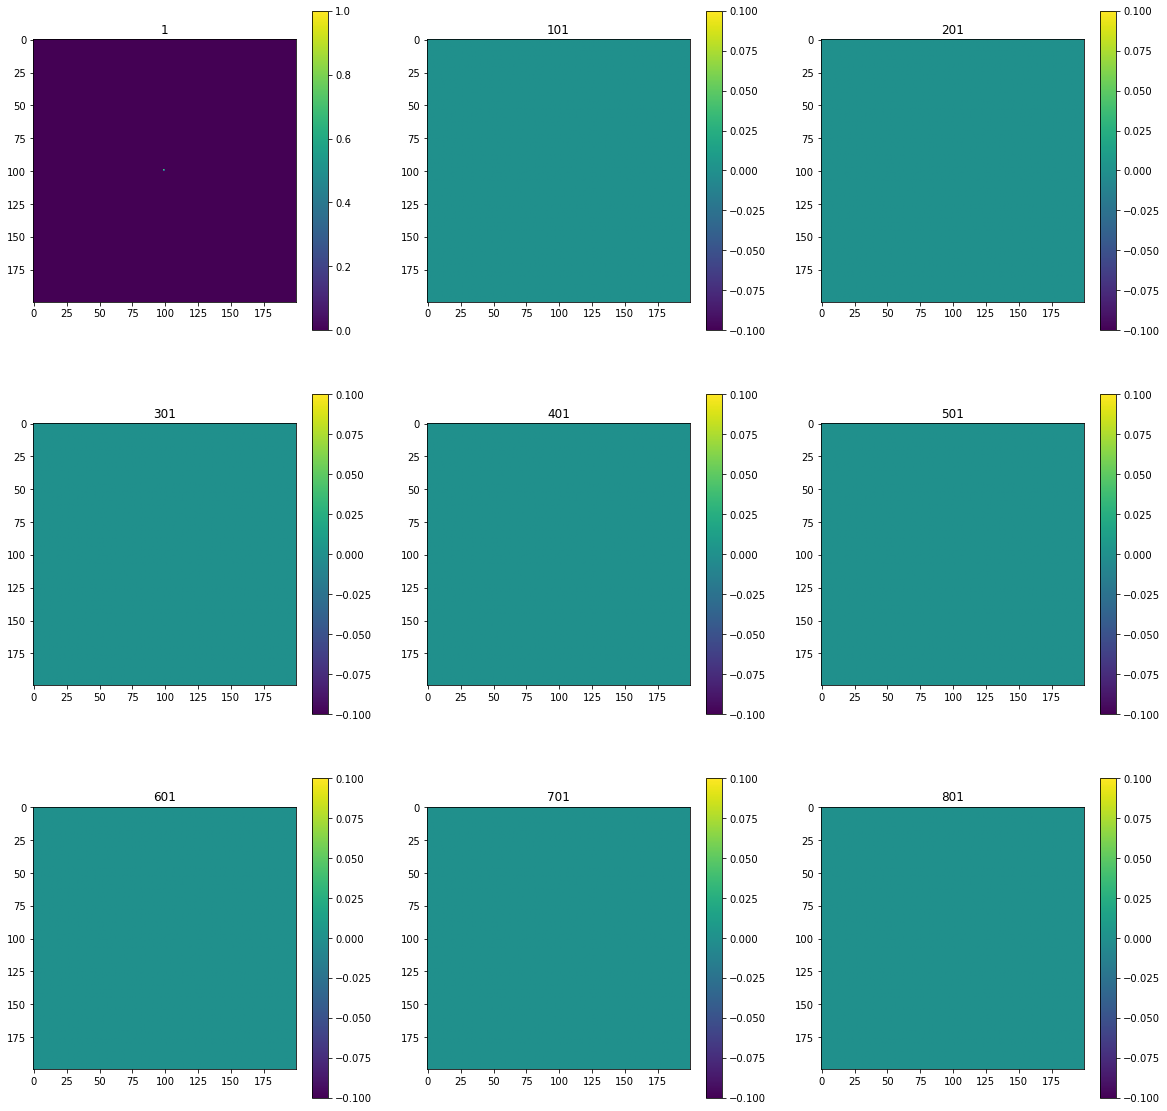

In [4]:
plt.figure(figsize=[20,20])
for i,step in enumerate(range(1,900,100)):
    plt.subplot(3,3,i+1)
    plt.imshow(source[step,:,:])
    plt.title(step)
    plt.colorbar()

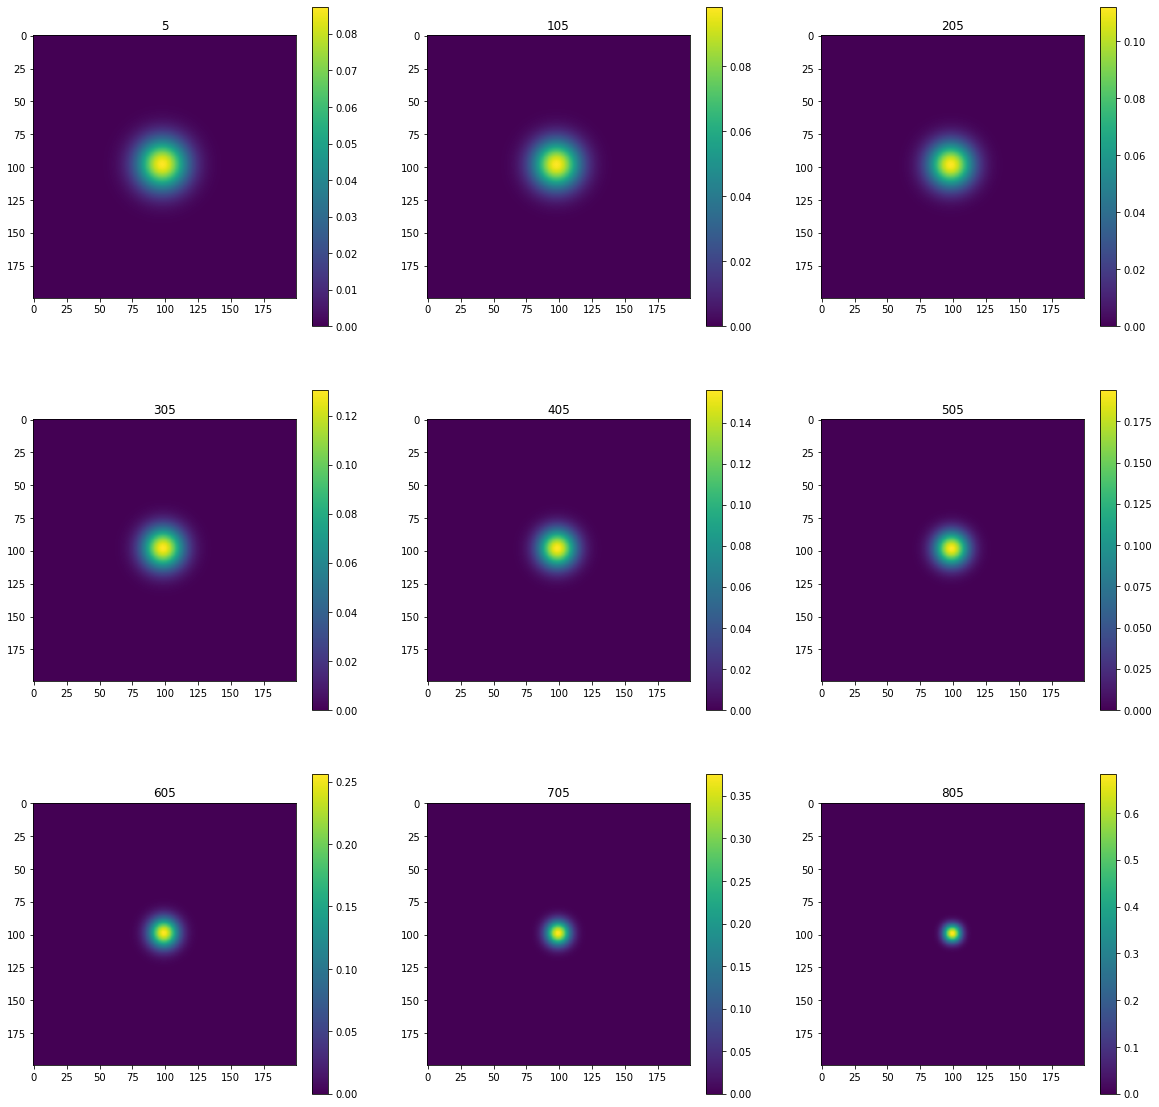

In [5]:
plt.figure(figsize=[20,20])
for i,step in enumerate(range(5,900,100)):
    plt.subplot(3,3,i+1)
    plt.imshow(v[step,:,:])
    plt.title(step)
    plt.colorbar()

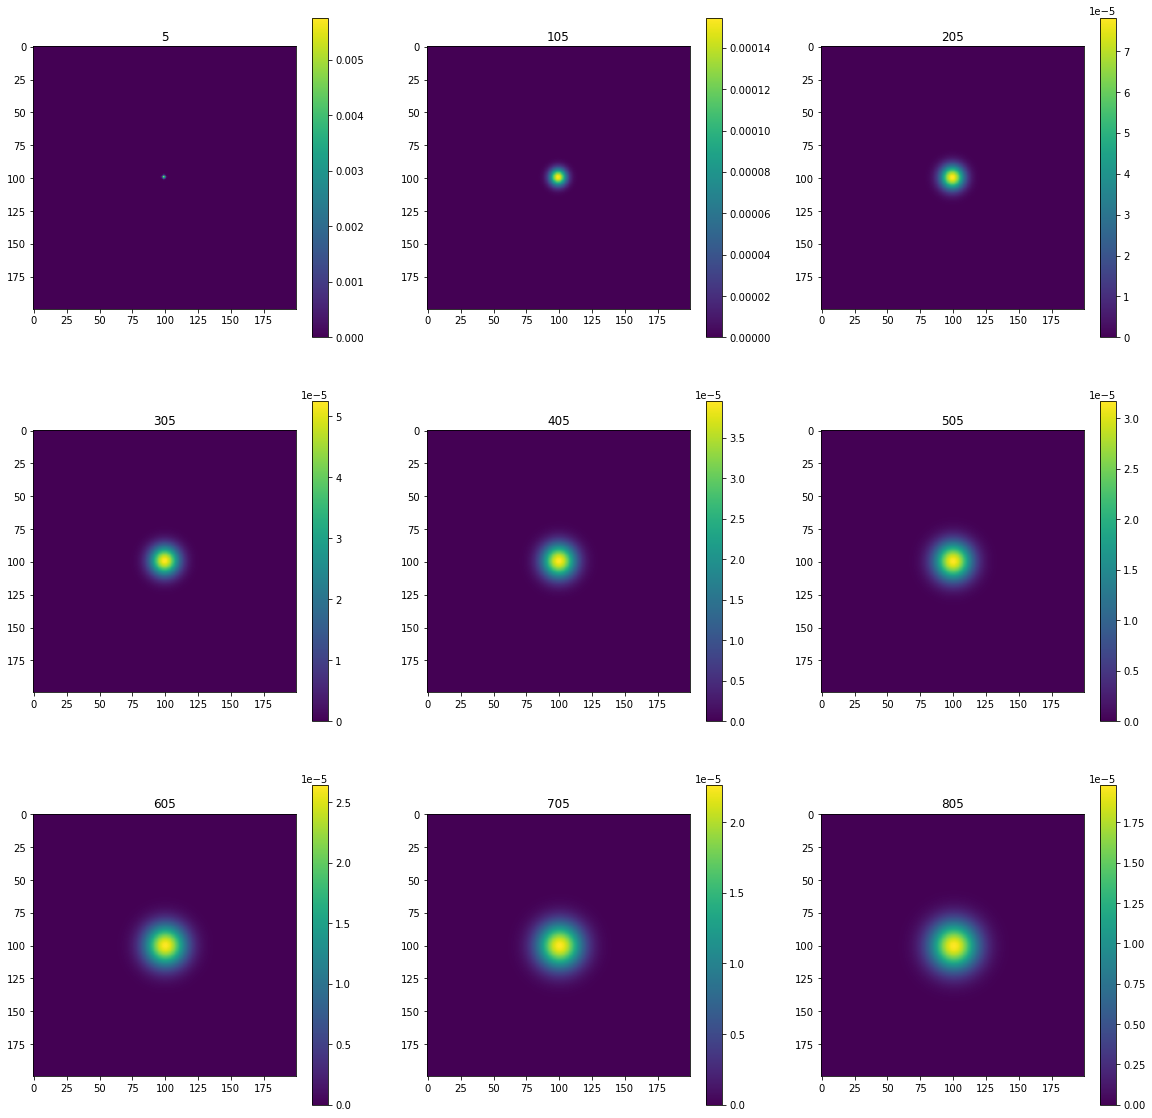

In [6]:
plt.figure(figsize=[20,20])
for i,step in enumerate(range(5,900,100)):
    plt.subplot(3,3,i+1)
    plt.imshow(m.conc[step,:,:])
    plt.title(step)
    plt.colorbar()

In [7]:
dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize()
np.sum(v*source)*dt*dx*dy

1.726895473771812e-05

In [8]:
dt*dx*dy

0.0002

In [9]:
np.sum(source)*dt*dx*dy

0.0002

In [10]:
m.computeObservations()

[[17.   9.5  9.5]]
850 900 95 105 95 105


array([1.72689547e-05])

In [ ]:
m.computeModelRegressors(sensors)

[[17.   9.5  9.5]]
850 900 95 105 95 105
